<a href="https://colab.research.google.com/github/Jenniferli6/XAI_Explainable_Deep_Learning/blob/main/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI Explainable Deep Learning
## Gender Classification with GradCAM Analysis
#### Jennifer Li

Face recognition technology has become deeply embedded in modern life — from Apple Face ID and identity verification, to cashless payments and airport security. While these technologies greatly improve convenience and safety, I’ve always been curious about what happens behind the scenes — particularly the interpretability, fairness, and potential bias in model decisions. Understanding why and how deep learning models interpret human faces is therefore crucial. It plays a key role in ensuring transparency, accountability, and public trust in AI-driven decision systems.

In this project, I used a pretrained ResNet-50 model to classify gender from facial images. The image samples were taken from the [FairFace dataset on Kaggle](https://www.kaggle.com/datasets/abdulwasay551/fairface-race), which includes diverse faces across race, age, and gender.

To interpret the model’s inner workings, I applied Grad-CAM and two of its enhanced variants, Grad-CAM++ and XGrad-CAM, to visualize the class-discriminative regions within each image. These techniques highlight which parts of a face contribute most to the model’s final classification decision.

By comparing the attention heatmaps across eight representative images, I aimed to visualize the regions the model relies on when predicting gender, to analyze whether those focus patterns are logically meaningful and how trustworthy the predictions are.

In [ ]:
# !pip install -q torch torchvision grad-cam

In [ ]:
import io
import os
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs("gender_cams", exist_ok=True) # create output directory

Using device: cuda


I selected 8 facial images in different demographic groups, from FairFace dataset:

- Black women and men
- Asian women and men
- Middle Eastern women and men
- White women and men

In [ ]:
image_urls = [
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/1002%20Black%20Woman.jpg",
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/10134%20Asian%20Woman.jpg",
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/10456%20Asian%20Man%20.jpg",
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/106%20Black%20Man.jpg",
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/10628%20Middle%20East%20Man.jpg",
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/12709%20Middle%20East%20Woman.jpg",
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/2016%20White%20Woman.jpg",
    "https://raw.githubusercontent.com/Jenniferli6/Explainable-Deep-Learning/main/Images/2184%20White%20Man.jpg",
]

print(f"✓ Loaded {len(image_urls)} image URLs")


✓ Loaded 8 image URLs


In [ ]:
class GenderModel(nn.Module):
    def __init__(self):
        super(GenderModel, self).__init__()
        resnet = models.resnet50(pretrained=True)  # Load pretrained ResNet50 as feature extractor
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])   # Remove the final classification layer
        num_features = 2048   # Get number of features from ResNet50

        # Gender classification head
        self.gender_head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Male/Female
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.gender_head(features)


The model architecture above consists of a ResNet-50 backbone pretrained on ImageNet, with custom classification heads for gender prediction.

ResNet-50 serves as a feature extractor, followed by a fully connected network with dropout regularization for binary gender classification (Female/Male).

In [ ]:
# Create model instance
model = GenderModel().to(device)
model.eval()

# Define class labels
GENDER_LABELS = ['Female', 'Male']

# Image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Target layer for GradCAM (last conv block in ResNet50 backbone)
target_layers = [model.backbone[-2][-1].conv3]

print("✓ Model initialized")
print(f"✓ Gender classes: {GENDER_LABELS}")


✓ Model initialized
✓ Gender classes: ['Female', 'Male']


In [ ]:
def load_and_preprocess_image(url):
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        img = Image.open(io.BytesIO(r.content)).convert("RGB")
        title = os.path.basename(url)

        # Resize for visualization
        img_vis = np.array(img.resize((224, 224))).astype(np.float32) / 255.0

        # Preprocess for model
        input_tensor = transform(img).unsqueeze(0).to(device)

        return img, title, img_vis, input_tensor
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None, None, None, None



In [ ]:
def predict_gender(input_tensor):
    with torch.no_grad():
        # Get predictions
        gender_logits = model(input_tensor)

        # Convert to probabilities
        gender_probs = F.softmax(gender_logits, dim=1)

        # Get top prediction
        gender_id = int(torch.argmax(gender_probs, dim=1).item())
        gender_conf = float(gender_probs[0, gender_id].item())

        return {
            'gender_id': gender_id,
            'gender_label': GENDER_LABELS[gender_id],
            'gender_conf': gender_conf
        }



In [ ]:
def generate_gradcam(input_tensor, target_id):
    targets = [ClassifierOutputTarget(target_id)]

    # Create GradCAM objects
    cam_grad = GradCAM(model=model, target_layers=target_layers)
    cam_pp = GradCAMPlusPlus(model=model, target_layers=target_layers)
    cam_x = XGradCAM(model=model, target_layers=target_layers)

    # Generate CAMs
    grayscale_cam_grad = cam_grad(input_tensor=input_tensor, targets=targets)[0]
    grayscale_cam_pp = cam_pp(input_tensor=input_tensor, targets=targets)[0]
    grayscale_cam_x = cam_x(input_tensor=input_tensor, targets=targets)[0]

    return {
        'GradCAM': grayscale_cam_grad,
        'GradCAM++': grayscale_cam_pp,
        'XGradCAM': grayscale_cam_x
    }


To understand the model's decision-making process, I implemented three GradCAM variants:

- GradCAM (Gradient-weighted Class Activation Mapping): Generates coarse localization maps highlighting important regions by computing gradients of the target class with respect to feature maps in the final convolutional layer.
- GradCAM++: An improved version that provides better visual explanations, especially for images with multiple instances of the same class. It uses a weighted combination of positive partial derivatives to capture pixel-wise importance more accurately.
- XGradCAM: Addresses limitations in handling multi-object scenarios by using normalized gradients, providing more balanced attention across relevant regions.

All three techniques were applied to the same target layer (the last convolutional block in ResNet-50's backbone) to ensure fair comparison.

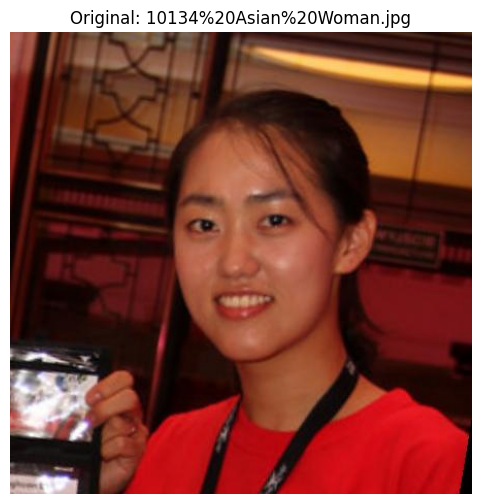


✓ Predictions:
  Gender: Female (51.61%)


In [ ]:
# To ensure steps all work correctly before applying to all images, I'll test pipeline on a single image first
test_url = image_urls[1]  # Asian Woman
img, title, img_vis, input_tensor = load_and_preprocess_image(test_url)

# Show original image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Original: {title}")
plt.axis('off')
plt.show()

# Get prediction
predictions = predict_gender(input_tensor)
print(f"\n✓ Predictions:")
print(f"  Gender: {predictions['gender_label']} ({predictions['gender_conf']:.2%})")



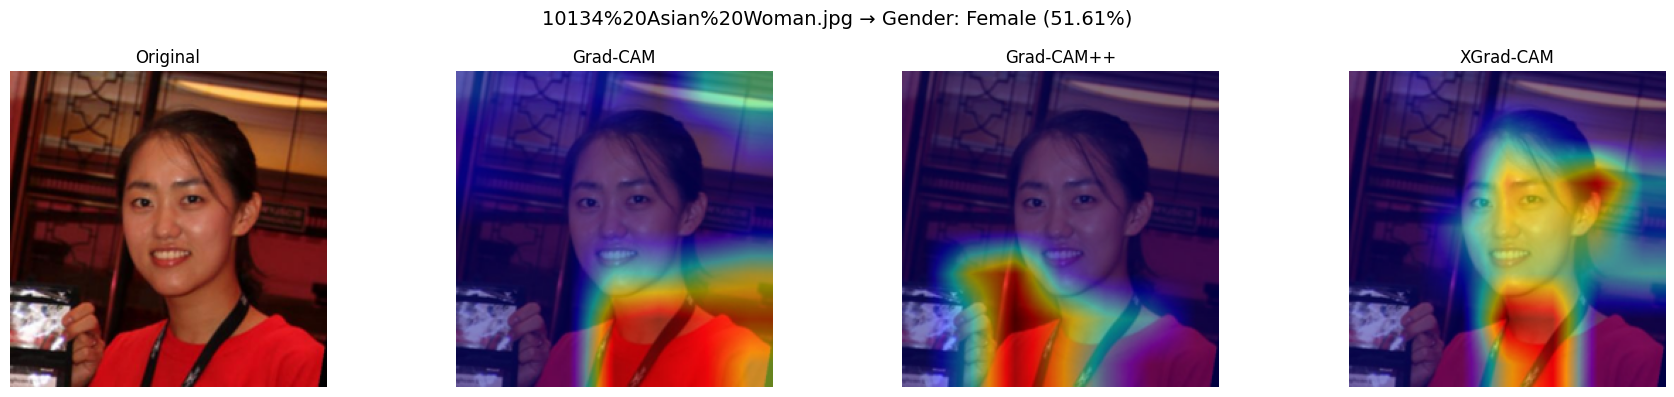

In [ ]:
# Generate GradCAM
cams_gender = generate_gradcam(input_tensor, predictions['gender_id'])

# Overlay on image
vis_grad = show_cam_on_image(img_vis, cams_gender['GradCAM'], use_rgb=True)
vis_pp = show_cam_on_image(img_vis, cams_gender['GradCAM++'], use_rgb=True)
vis_x = show_cam_on_image(img_vis, cams_gender['XGradCAM'], use_rgb=True)

# Display
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].imshow((img_vis * 255).astype(np.uint8))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(vis_grad)
axes[1].set_title('Grad-CAM')
axes[1].axis('off')

axes[2].imshow(vis_pp)
axes[2].set_title('Grad-CAM++')
axes[2].axis('off')

axes[3].imshow(vis_x)
axes[3].set_title('XGrad-CAM')
axes[3].axis('off')

plt.suptitle(f'{title} → Gender: {predictions["gender_label"]} ({predictions["gender_conf"]:.2%})',
             fontsize=14)
plt.tight_layout()
plt.show()

The test is okay!

In [ ]:
# Now, Process all images
results = []

for i, url in enumerate(image_urls):
    print(f"\n[{i+1}/{len(image_urls)}] Processing: {os.path.basename(url)}")

    # Load image
    img, title, img_vis, input_tensor = load_and_preprocess_image(url)

    if img is None:
        print(f"  ✗ Skipping due to load error")
        continue

    # Get predictions
    predictions = predict_gender(input_tensor)
    print(f"  Gender: {predictions['gender_label']} ({predictions['gender_conf']:.2%})")

    # Generate GradCAM for GENDER classification
    cams_gender = generate_gradcam(input_tensor, predictions['gender_id'])

    # Create overlays
    vis_grad_gender = show_cam_on_image(img_vis, cams_gender['GradCAM'], use_rgb=True)
    vis_pp_gender = show_cam_on_image(img_vis, cams_gender['GradCAM++'], use_rgb=True)
    vis_x_gender = show_cam_on_image(img_vis, cams_gender['XGradCAM'], use_rgb=True)

    # Save images
    out_base = os.path.join("gender_cams", title.replace(" ", "_").replace("%20", "_"))
    Image.fromarray(vis_grad_gender).save(out_base + "_Gender_GradCAM.png")
    Image.fromarray(vis_pp_gender).save(out_base + "_Gender_GradCAMPP.png")
    Image.fromarray(vis_x_gender).save(out_base + "_Gender_XGradCAM.png")

    # Store results
    results.append({
        'title': title,
        'predictions': predictions,
        'orig': (img_vis * 255).astype(np.uint8),
        'cams_gender': {
            'GradCAM': vis_grad_gender,
            'GradCAM++': vis_pp_gender,
            'XGradCAM': vis_x_gender
        }
    })

print(f"\n✓ Successfully processed {len(results)} images!")



[1/8] Processing: 1002%20Black%20Woman.jpg
  Gender: Male (50.98%)

[2/8] Processing: 10134%20Asian%20Woman.jpg
  Gender: Female (51.61%)

[3/8] Processing: 10456%20Asian%20Man%20.jpg
  Gender: Female (50.69%)

[4/8] Processing: 106%20Black%20Man.jpg
  Gender: Male (54.73%)

[5/8] Processing: 10628%20Middle%20East%20Man.jpg
  Gender: Male (50.65%)

[6/8] Processing: 12709%20Middle%20East%20Woman.jpg
  Gender: Female (50.93%)

[7/8] Processing: 2016%20White%20Woman.jpg
  Gender: Male (53.89%)

[8/8] Processing: 2184%20White%20Man.jpg
  Gender: Male (52.97%)

✓ Successfully processed 8 images!


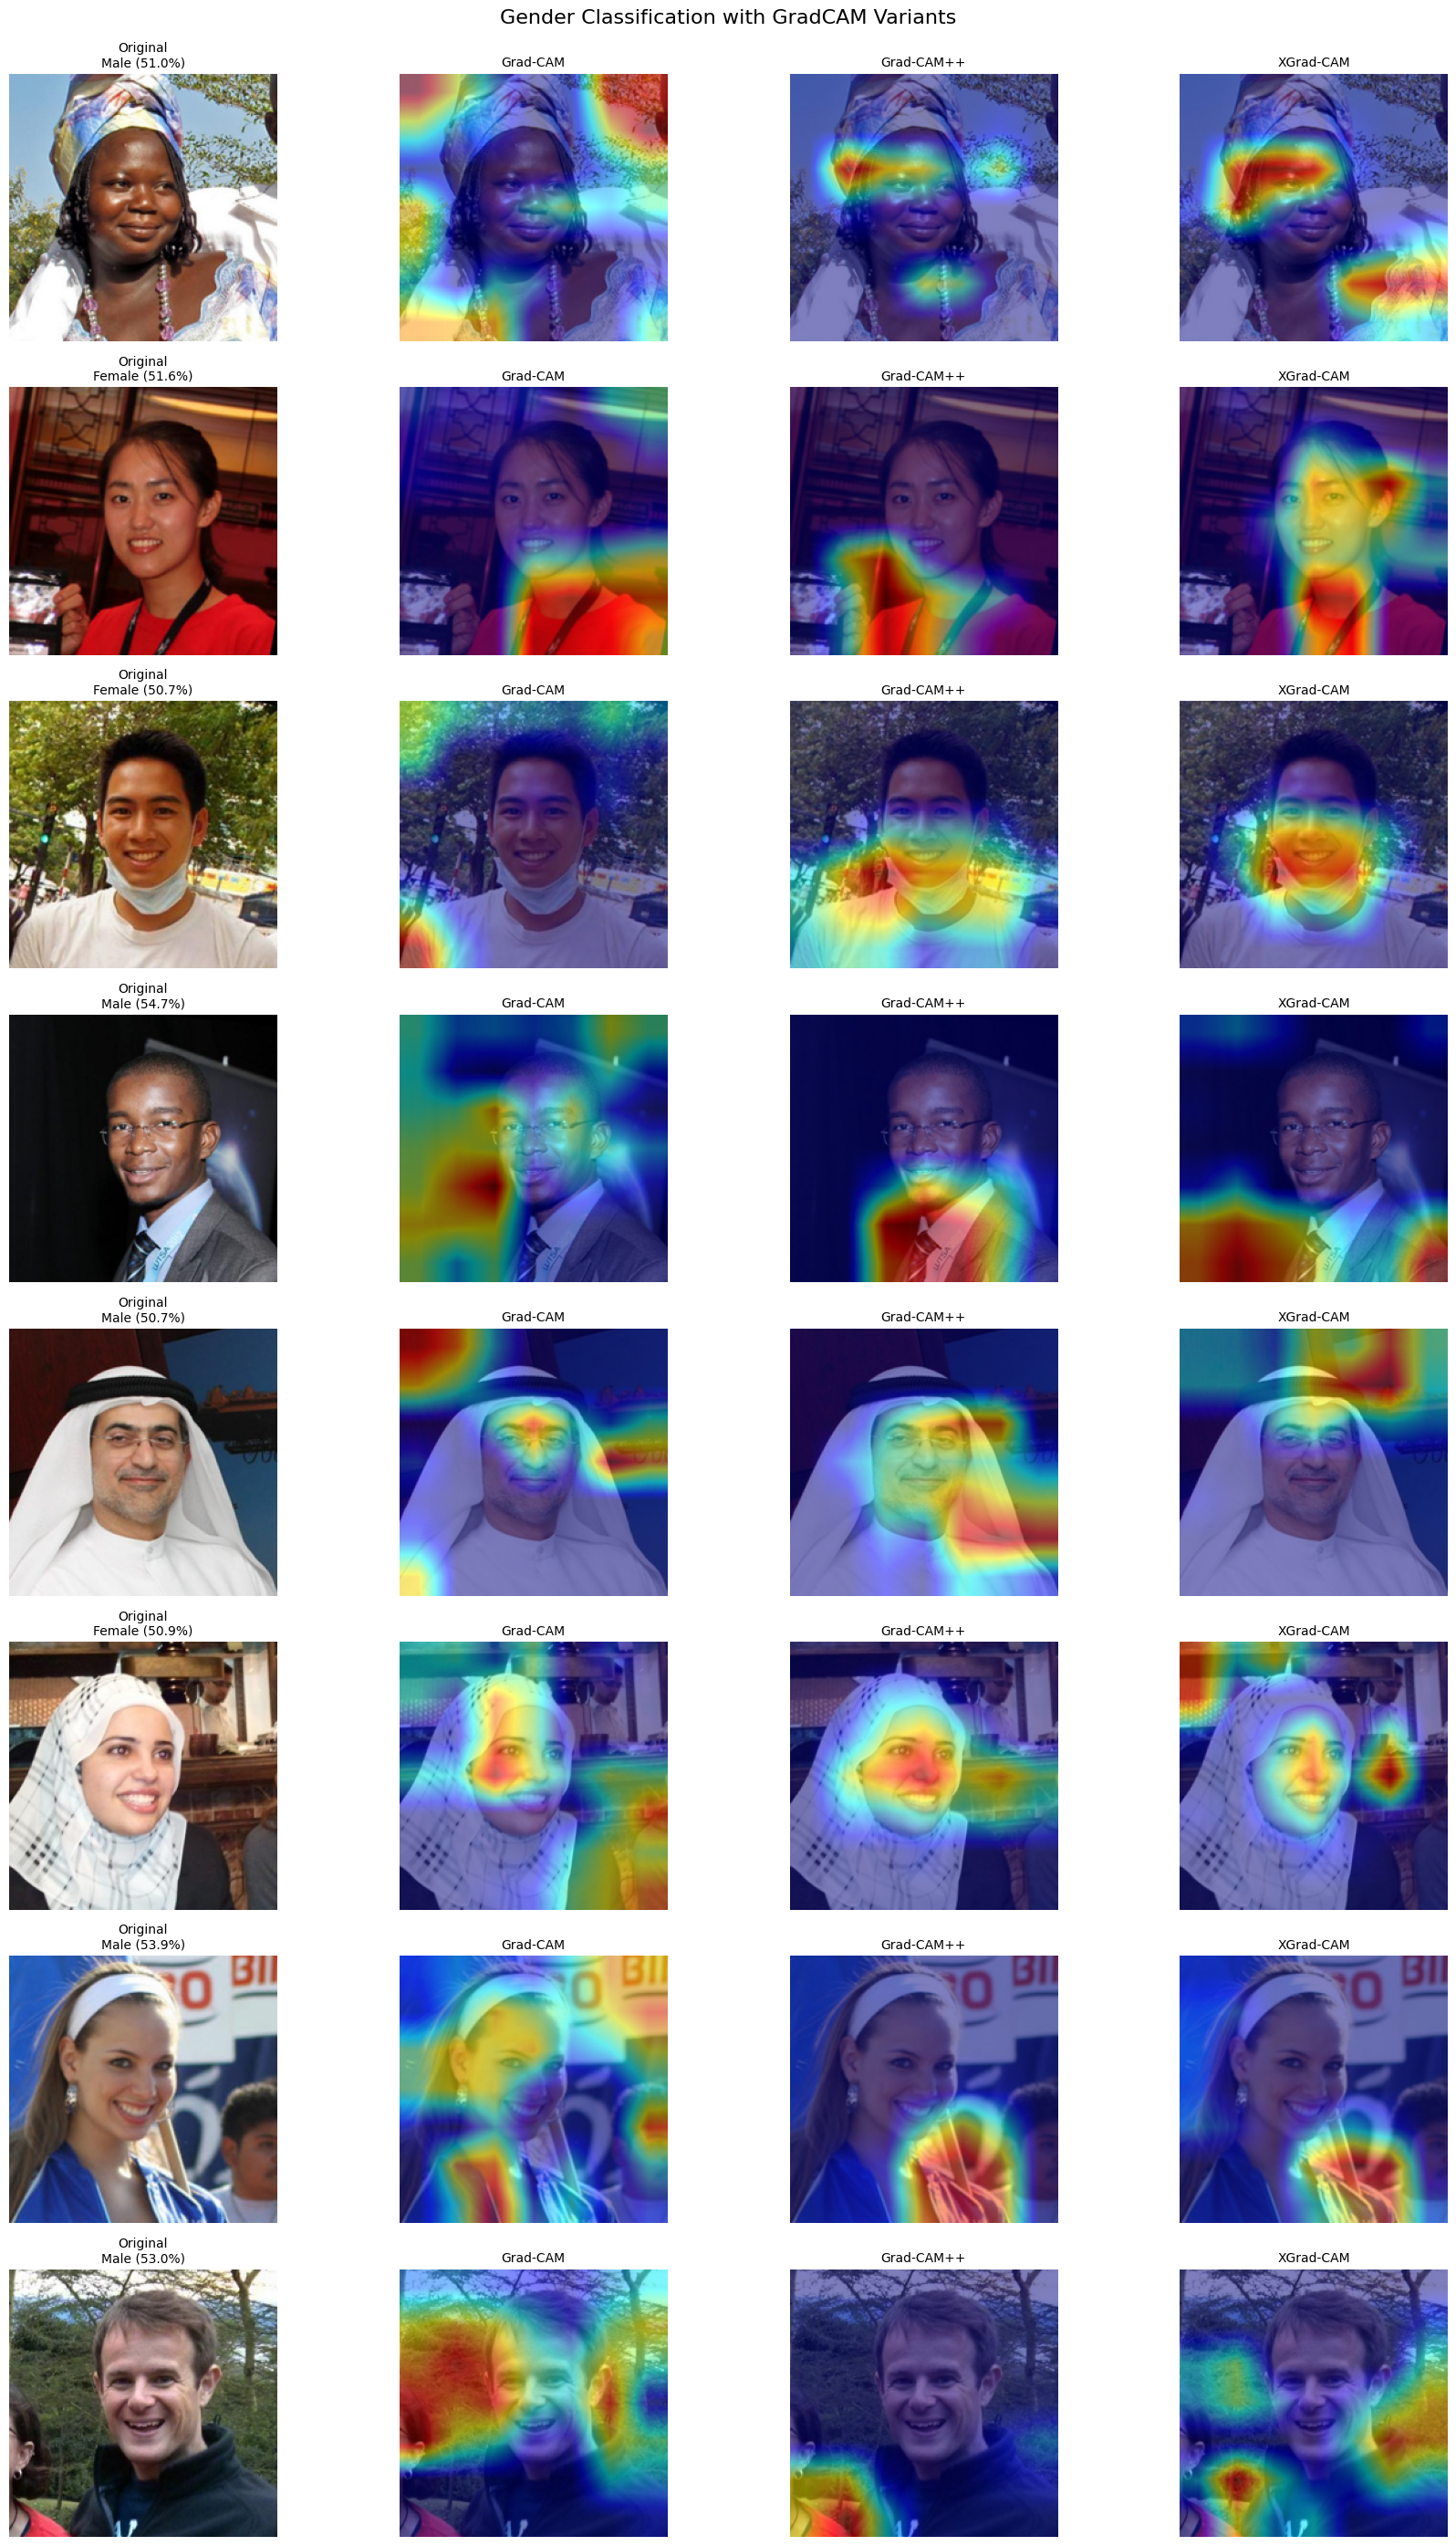

In [ ]:
# Visualize all results
cols = 4
rows = len(results)

plt.figure(figsize=(4*4.5, rows*3.5))

for r, item in enumerate(results):
    # Original
    ax = plt.subplot(rows, cols, r*cols + 1)
    ax.imshow(item['orig'])
    pred = item['predictions']
    ax.set_title(f"Original\n{pred['gender_label']} ({pred['gender_conf']:.1%})", fontsize=10)
    ax.axis("off")

    # Grad-CAM
    ax = plt.subplot(rows, cols, r*cols + 2)
    ax.imshow(item['cams_gender']['GradCAM'])
    ax.set_title("Grad-CAM", fontsize=10)
    ax.axis("off")

    # Grad-CAM++
    ax = plt.subplot(rows, cols, r*cols + 3)
    ax.imshow(item['cams_gender']['GradCAM++'])
    ax.set_title("Grad-CAM++", fontsize=10)
    ax.axis("off")

    # XGrad-CAM
    ax = plt.subplot(rows, cols, r*cols + 4)
    ax.imshow(item['cams_gender']['XGradCAM'])
    ax.set_title("XGrad-CAM", fontsize=10)
    ax.axis("off")

plt.suptitle("Gender Classification with GradCAM Variants", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


In [ ]:
# Prediction summary
print("\n" + "="*70)
print("DETAILED PREDICTION SUMMARY")
print("="*70)
print(f"{'Image':<45} {'Gender':<20}")
print("="*70)

for item in results:
    pred = item['predictions']
    gender_str = f"{pred['gender_label']} ({pred['gender_conf']:.1%})"
    print(f"{item['title']:<45} {gender_str:<20}")



DETAILED PREDICTION SUMMARY
Image                                         Gender              
1002%20Black%20Woman.jpg                      Male (51.0%)        
10134%20Asian%20Woman.jpg                     Female (51.6%)      
10456%20Asian%20Man%20.jpg                    Female (50.7%)      
106%20Black%20Man.jpg                         Male (54.7%)        
10628%20Middle%20East%20Man.jpg               Male (50.7%)        
12709%20Middle%20East%20Woman.jpg             Female (50.9%)      
2016%20White%20Woman.jpg                      Male (53.9%)        
2184%20White%20Man.jpg                        Male (53.0%)        


## Reflection


### Demographic-Specific Observations (Visual Cues and Surprising findings)

**Black Woman (Misclassified as Male, 51.0%)**

This was a misclassification. As we can see above, the Grad-CAM maps show attention scattered across the headwrap and upper forehead rather than core facial features. Grad-CAM++ and XGrad-CAM slightly refocus on the eyes and nose, but overall the model seems distracted by the bright clothing and background. It seems that the mdoel picked up on contextual color and texture patterns instead of facial shape.


**Asian Woman (Correctly Classified, 51.6%)**

Here, all three techniques focus heavily on the lower facial region and red clothing, while XGradCAM highlights the face and upper body more evenly. The strong attention to clothing color rather than facial features suggests the model may be relying on spurious correlations rather than biologically relevant characteristics.

**Asian Man (Misclassified as Female, 50.7%)**

The attention spreads broadly across the face and shirt collar, with a slight drift toward background areas. GradCAM spreads attention broadly across the face and background foliage, GradCAM++ focuses tightly on the mask and mouth region, and XGradCAM emphasizes the entire face-mask area as a cohesive unit. The near 50-50 prediction probability reveals complete model uncertainty. This case demonstrates how occlusions can severely impair model performance.

**Black Man (Correctly Classified, 54.7%)**

The heatmaps are centered mainly on facial features, glasses, and formal attire. GradCAM shows broad activation across the left side of the face and suit jacket, GradCAM++ sharpens focus on the central face and tie area, while XGradCAM distributes attention across facial features and shoulders. This image received the highest confidence score among all predictions, suggesting the combination of formal business attire, glasses, and clear facial features aligned strongly with the model's learned representations of male subjects.

**Middle Eastern Man (Correctly Classified, 50.7%)**

All three techniques show strong activation on the traditional white headwear (ghutra), with attention also on the central facial features. GradCAM creates a broad effect around the head and face, GradCAM++ concentrates on the forehead and headwear with sharp boundaries, and XGradCAM balances attention between the face and the distinctive white headdress. Despite correct classification, the low confidence suggests the model found this image challenging.

**Middle Eastern Woman (Correctly Classified, 50.9%)**

All three methods showing the head covering as a primary focus. Grad-CAM++ and XGrad-CAM clearly highlight the eyes and smile region, while Grad-CAM remains more diffuse. The near 50-50 confidence reveals extreme uncertainty despite correct prediction.

**White Woman (Misclassified as Male, 53.9%)**

Surprisingly, all three methods show strong activation around the hairband and background, not the face. This misclassification has a relatively higher confidence (53.9%). Not sure if it was because the model incorrectly associated the athletic context, headband, and sports attire with male gender. If that was true, this result might reveal potential stereotypical bias where sports-related imagery may be disproportionately linked to male classifications in the training data.

**White Man (Correctly Classified, 53.0%)**

The activation maps show broad, diffuse attention across the entire face, hair, and outdoor background. GradCAM produces widespread activation covering the face and natural background, GradCAM++ focuses more precisely on the central facial region and smile, while XGradCAM creates a concentrated hotspot on the lower face with additional attention to surrounding areas. This prediction achieved moderate confidence, and the visualizations suggest the model considered multiple facial features holistically.

### Pattern Differences Across GradCAM Analysis

- GradCAM tends to produce broader, more diffuse activation maps that spread across larger regions of the face, including background elements. This can make it difficult to pinpoint specific features driving the decision.
- GradCAM++ generates more focused attention maps with sharper boundaries, concentrating on specific facial features such as the central face region, eyes, and lower face. The heat maps show clearer differentiation between highly relevant and less relevant regions.
- XGradCAM provides the most balanced visualization, often highlighting multiple distinct facial regions (face, hair, shoulders) with relatively equal emphasis. This approach captures a more holistic view of the features contributing to the prediction.

### Importance of Model Explainability

Model explainability is critically important in gender classification and demographic analysis because these systems directly impact people's lives and can perpetuate or amplify societal biases.

As this project demonstrates, 5 out of 8 predictions (62.5%) were correct, among which 3 out of 4 women misclassified as men. Also, all predictions hover around 50-55%, indicating high uncertainty. When making decisions about gender classification, model considered factors such as clothing color, sports contexts, cultural headwear, and background elements rather than facial features alone.

These findings revealed which features most strongly influenced the model’s predictions through Grad-CAM analysis, showing the importance of explainability techniques in fairness auditing, bias mitigation, and ethical AI development.


*Note: ChatGPT 5 and Claude Sonnet 4.5 were used to help debug the code and draft Github Repo ReadMe.*